In [8]:
#def init():
    #CHANGE THIS TO YOUR TRAIN FOLDER
image_folder = 'C:/Study/Semester2/Machine Learning/ML_images/Training' 
#image_folder = 'C:/Users/danie/Desktop/Training_ML'

TOO_SMALL = 200000
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
img_height = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
img_width = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
epochs = 10 #Start with 1, and increase to 10, 100, 500, 1000 and 3000. 11 is the recommended number of runs through the training dataset. We will probably have to tune this. 
#total_training = total number of training data len()
batch_size = 1 #test different ones from 1 to 2, 5, 10, etc
total_images = 1

In [9]:
#pip install opencv-python

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import cv2
import glob
import pandas as pd
import joblib

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io,color
from skimage.io import imread_collection #loads a collection of images
from skimage.io import imread, imshow
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
#Define sizes of images based on their resolution
#Image shape and resolution

#TODO make the IMG sizes make sense


def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [12]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg')

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    print("processing", df_length, "photos for training")
    
    height= []
    width = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height.append(img.shape[0])
        width.append(img.shape[1])
        
    df["height"] = height
    df["width"] = width
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [13]:
#PCA rgb then pass to prep_img as an rgb image

def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
        
    return RGB_compressed

In [14]:
# image padding

def rgb_pad(image):
    
    height = image.shape[0]
    width = image.shape[1]

    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    MAX = 1888
    
    if height % 2 == 0:
        top = int((MAX - height)/ 2)
        bottom = int((MAX - height)/ 2)
    else: 
        top = int((MAX - (height-1))/ 2)
        bottom = int(((MAX - (height-1))/ 2)-1)

    if width % 2 == 0:
        left = int((MAX - width)/ 2)
        right = int((MAX - width)/ 2)
    else: 
        left = int((MAX - (width-1))/ 2)
        right = int(((MAX - (width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right,
    cv2.BORDER_CONSTANT,value=WHITE)

    return image

In [15]:
#Debugged function
def prep_img(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category) #imgRGB, image_size_category
    #RGB_compressed[400][400]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB_compressed)
    
    print("image is padded")
    padded_image = rgb_pad(RGB_compressed)
    #padded_image[1000][1000]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(padded_image)
    
    #image_pca = np.float32((1.0/255)*image_pca) # #The rgb_compressed come out in RGB scaled data already
    print("image converted to LAB")
    padded_LAB = cv2.cvtColor(padded_image, cv2.COLOR_RGB2Lab) #convert padded RGB compressed to LAB
    padded_LAB = padded_LAB/np.amax(padded_LAB) #scaled to -1/1
    #imgLAB = np.clip(imgLAB, 0, 1)

    
    #separate L and AB color channels
    Y = padded_LAB[:, :,1:]
    #Y = Y / 128 #comment out when show predicted
    #Y = Y.tolist()
    X = padded_LAB[:, :, 0] #.tolist()
    #print(X[1000])
    #plt.figure(figsize=(10, 10))
    #plt.imshow(X)
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [16]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

# Use the code below to process ALL photos and feed them to the model!!!

In [17]:
df = create_dataframe(image_folder)
prep_dataframe(df)

#add padd(image).tolist()
#caused TypeError: unsupported operand type(s) for /: 'list' and 'int'


processing 151 photos for training
dropped  9 photos because they were too large to process
dropped  5 photos because they were too small to process
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image converted to LAB
image processed
image is padded
image conv

In [18]:
def mode(): 
    model1 = Sequential([
        #encoder
        Conv2D(128, 2, strides = 2, padding = "same", activation = "relu", input_shape= (1888, 1888, 1)), #testing shape changes
        Conv2D(256, 2, strides = 2, padding = "same", activation = "relu"), 
        Conv2D(256, 2, strides = 2, padding = "same", activation = "relu"), 

        #decoder
        Conv2D(256, 2, padding = "same", activation = "relu"), 
        UpSampling2D(2),
        Conv2D(128, 2, padding = "same", activation = "relu"), 
        UpSampling2D(2), 
        Conv2D(2, 2, padding = "same", activation = "tanh"),
        UpSampling2D(2),
    ])
    model1.compile(optimizer ="adam", loss = "mse", metrics = ["accuracy"])
    return model1

In [23]:
model1 = mode()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 944, 944, 128)     640       
                                                                 
 conv2d_1 (Conv2D)           (None, 472, 472, 256)     131328    
                                                                 
 conv2d_2 (Conv2D)           (None, 236, 236, 256)     262400    
                                                                 
 conv2d_3 (Conv2D)           (None, 236, 236, 256)     262400    
                                                                 
 up_sampling2d (UpSampling2D  (None, 472, 472, 256)    0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 472, 472, 128)     131200    
                                                        

In [19]:
len(X_train)

137

In [20]:
len(Y_train)

137

In [21]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [24]:
epochs = 1
history = model1.fit(train_data, batch_size = batch_size, epochs = epochs, verbose = 2)  # add validation_split = 0.2

137/137 - 438s - loss: 0.0029 - accuracy: 0.3929 - 438s/epoch - 3s/step


In [26]:
filename = 'my_model_tf'
model1.save(filename)

INFO:tensorflow:Assets written to: my_model_tf\assets


## Test one image

In [ ]:
#import model

In [27]:
# load the model from disk
#reconstructed_model = keras.models.load_model("my_model_tf")

In [28]:
test_path = "C:/Study/Semester2/Machine Learning/ML - Yes Photos/1900s_loose_bw_0036_mom.jpg"

In [29]:
def prep_img_test(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category) #imgRGB, image_size_category
    #RGB_compressed[400][400]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB_compressed)
    
    print("image is padded")
    padded_image = rgb_pad(RGB_compressed)
    #padded_image[1000][1000]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(padded_image)
    
    #image_pca = np.float32((1.0/255)*image_pca) # #The rgb_compressed come out in RGB scaled data already
    print("image converted to LAB")
    padded_LAB = cv2.cvtColor(padded_image, cv2.COLOR_RGB2Lab) #convert padded RGB compressed to LAB
    padded_LAB = padded_LAB/np.amax(padded_LAB) #scaled to -1/1
    #imgLAB = np.clip(imgLAB, 0, 1)

    
    #separate L and AB color channels
    Y = padded_LAB[:, :,1:]
    #Y = Y / 128 #comment out when show predicted
    #Y = Y.tolist()
    X = padded_LAB[:, :, 0] #.tolist()
    #print(X[1000])
    #plt.figure(figsize=(10, 10))
    #plt.imshow(X)
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [30]:
CL, BW = prep_img_test(test_path)
#test_data = tf.data.Dataset.from_tensor_slices(BW)
test_predict = model1.predict(BW) #what shape does the prediction takes?

image is padded
image converted to LAB
image processed


In [31]:
type(test_predict)

numpy.ndarray

In [32]:
test_predict.shape # use this to merge

(1, 1888, 1888, 2)

In [33]:
BW.shape # use this to merge

(1, 1888, 1888, 1)

In [34]:
CL.shape

(1, 1888, 1888, 2)

#### merge with d stack

In [35]:
test_predict_reshaped = test_predict[0,:,:,:]

In [36]:
test_predict_reshaped.shape

(1888, 1888, 2)

In [37]:
test_predict_reshaped[0][0]

array([-0.00875675,  0.01105275], dtype=float32)

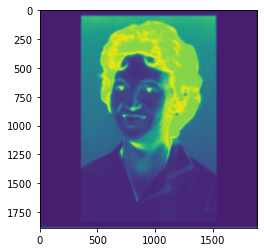

In [38]:
plt.imshow(test_predict_reshaped[:,:,0])

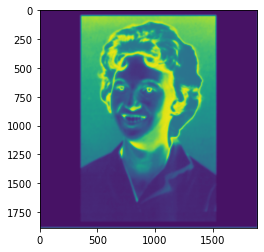

In [39]:
plt.imshow(test_predict_reshaped[:,:,1])

In [40]:
BW_reshaped  = BW[0,:,:,:]

In [41]:
BW_reshaped.shape

(1888, 1888, 1)

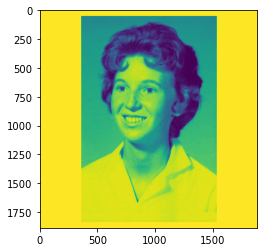

In [42]:
plt.imshow(BW_reshaped)

In [43]:
test_merged = np.dstack((test_predict_reshaped, BW_reshaped))

In [44]:
test_merged.shape

(1888, 1888, 3)

In [45]:
test_merged[0][0]

array([-0.00875675,  0.01105275,  1.        ], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


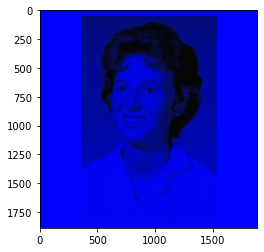

In [46]:
plt.imshow(test_merged)

In [47]:
#test_merged_converted = color.Lab2rgb(test_merged)

In [48]:
test_merged_rgb = cv2.cvtColor(test_merged, cv2.COLOR_RGB2Lab) 

In [49]:
test_merged_rgb[0][0] # this is weird

array([  32.41577,   78.8125 , -107.65625], dtype=float32)

In [50]:
test_merged_rgb_scaled = (test_merged_rgb/255).astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


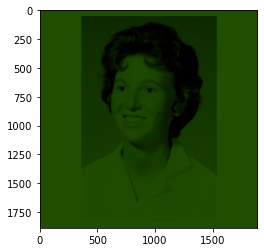

In [51]:
#plt.imshow(test_merged_rgb)
plt.imshow(test_merged_rgb_scaled )

In [53]:
plt.imsave('result1.jpg', test_merged_rgb)

ValueError: Floating point image RGB values must be in the 0..1 range.

##### a way to merge the prediction

In [69]:
#pastes predicted AB to RGB blank canvas
canvas = np.zeros((1888,1888,3))
canvas[:,:,0] = BW[0][:,:,0]
canvas[:,:,1:] =test_predict[0]

In [74]:
#convert AB (in RGB space) to rgb photo
rgb_converted = color.lab2rgb(canvas)

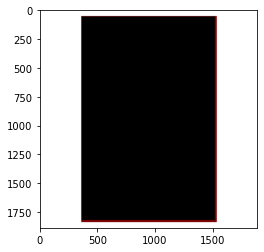

In [75]:
plt.imshow(rgb_converted)

In [ ]:
lab_2rgb = cv2.cvtColor(canvas, cv2.COLOR_RGB2Lab)

In [58]:
lab_to = 

In [59]:
lab_merge.shape

(1888, 1888, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


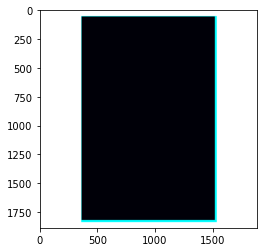

In [64]:
plt.imshow(canvas)

In [ ]:
#Test input array

In [156]:
img_path1 = 'C:/Study/Semester2/Machine Learning/ML - Yes Photos/1900s_loose_bw_0036_mom.jpg'
Y01, X01 = prep_img(img_path1)

image converted to LAB
image processed


In [161]:
type(X01[0])

list

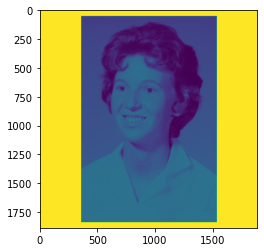

In [157]:
#show AB channel of the image
plt.imshow(X01) #X01[0,:,:,0]

In [130]:
df_X01 = pd.DataFrame(X01[0,:,:,0])

In [120]:
df_Y01 = pd.DataFrame(Y01[0,:,:,0])

In [121]:
df_Y01.describe()

,0,1,2,3,4,5,6,7,8,9,...,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,...,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
25%,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
50%,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
75%,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
max,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,...,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188,1.992188
